
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1RxT500njL2vYaFF9o0TRTfw1RY5fdzvB)

Welcome to [@jonathandinu](https://twitter.com/jonathandinu)'s "blog"... for a list of posts please see the index on Github: [https://github.com/jonathandinu/generative-ai-notebooks](https://github.com/jonathandinu/generative-ai-notebooks).

Comments are welcome and encouraged. You can do this on [Github](https://github.com/jonathandinu/generative-ai-notebooks/discussions) or directly in Colab (if you sign in) on the entire notebook or on a cell by cell basis.

![commenting in Google Colab](https://jonathandinu.github.io/generative-ai-notebooks/images/comment_in_colab.png)

__Copyright Notice__

©️ 2024 Jonathan Dinu. All Rights Reserved. Removal of this copyright notice or reproduction in part or whole of the text, images, and/or code is expressly prohibited. For permission to use the content please contact copyright@jonathandinu.com.

---

# PyTorch for the Impatient or: Deep Learning is just a Bunch of Regressions

In this post, I'm going to hopefully convince you that neural networks (and deep learning in general) are really just a bunch of regressions. Linear and logistic regressions. Like you might have learned about in a machine learning 101 or data science class. And more fundamentally, the equation of a line you were taught in high school (hopefully). So let's start from those basics and work our way up to a proper deep neural network, and along the way get introduced to PyTorch to understand why deep learning frameworks are incredibly useful and often necessary.

> This isn't going to be an exhaustive treatment of PyTorch or it's extended ecosystem, entire books could be dedicated to that (and have been). Instead this will be "just enough PyTorch to be dangerous" so to say.

## What is Pytorch
![](https://jonathandinu.github.io/generative-ai-notebooks/images/pytorch-handshake.jpg)

At it's core (and a gross oversimplication), PyTorch is _simply_ a Python package that marries a `numpy`-like API for large multi-dimensional arrays on GPUs (and other "accelerators") with an automatic differentiation library for computing derivatives of computation graphs. Essentially you can think of it as a high level interface that translates human friendly mathematical operations (like matrix multiply) into optimized low level computational operations that can efficiently execute on GPUs.

Thankfully, PyTorch abstracts away most of this complexity from end users, but it is helpful when debugging to have a conceptual understanding of what is happening behind the scenes---for example if you get a notorious GPU out-of-memory error (OOM). And lastly, "PyTorch" is much more than the core library that interfaces with GPUs, but really an entire ecosystem of interoperable libraries centered around building deep neural networks (much like `numpy`'s relation to the larger scientific Python ecosystem).

## Tensor? I hardly know her!

The main data structure in PyTorch that you most always operate over is the [`Tensor`](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html). Now these aren't your [physicists'](https://en.wikipedia.org/wiki/Tensor#/media/File:Components_stress_tensor.svg) or mathematicians' tensors, though they are similar. In PyTorch (and most every other DL framework) tensors are just a fancy name for multi-dimensional arrays.

In [ ]:
import torch
import numpy as np

# initialize a tensor with 60 elements
x = torch.arange(60).reshape((3, 4, 5))

# inspect the tensor dimensions...
# you will use this ALOT when debugging
print(x.shape)

x

torch.Size([3, 4, 5])


tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]],

        [[40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49],
         [50, 51, 52, 53, 54],
         [55, 56, 57, 58, 59]]])

And PyTorch `Tensors` can even transparently convert to/from `numpy` arrays. This is invaluable for interoperating with other libraries in the scientific Python ecosystem that provide functionality not present in Pytorch (such as the computer vision utilities in [`scikit-image`](https://scikit-image.org/) or [OpenCV](https://docs.opencv.org/4.x/index.html)). Pytorch _does_ have dedicated libraries for working with specific types of media like `torchvision`, `torchtext`, and `torchaudio`, but these have more limited functionality than a general purpose library for the same media (i.e. `scikit-image`) and are usually specific to only the utilities that support deep learning applications.

In [ ]:
numpy_tensor = x.numpy()
torch.equal(x, torch.from_numpy(numpy_tensor))

True

So far, PyTorch seems like _just_ a `numpy` clone, but the real power of PyTorch comes from it's ease of moving data to/from GPU devices to run accelerated operations on that data. And its ability to automatically compute derivatives of arbitrary functions over tensors.

## To GPU, or not to GPU?

> if running in Colab, you may need to enable a GPU for the notebook: https://colab.research.google.com/notebooks/gpu.ipynb

In [ ]:
if torch.cuda.is_available():
    # move a tensor from the CPU to the GPU
    x.to("cuda")

    # initialize a tensor on the GPU
    x = torch.arange(60, device="cuda").reshape((3, 4, 5))

# move it back to the CPU to convert it to a numpy array
x.cpu().numpy()

array([[[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]],

       [[20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34],
        [35, 36, 37, 38, 39]],

       [[40, 41, 42, 43, 44],
        [45, 46, 47, 48, 49],
        [50, 51, 52, 53, 54],
        [55, 56, 57, 58, 59]]])

Sometimes even if you always do _computation_ on the GPU, you might want to (or need to) move tensors and models on/off due to memory constraints. For example, like when you are performing model _inference_ on a large model like Stable Diffusion that has ~3.5 __billion__ parameters. For model _training_ purposes, PyTorch's built-in `DataLoader` is specifically designed to efficiently read and process data before moving it to the GPU, since most datasets used for generative AI applications cannot fit entirely in your GPU's memory.

> While PyTorch makes it trivial from a developer's perspective to move tensors to/from the GPU, these moves do not come at zero cost. [Data I/O](https://arxiv.org/abs/2306.12517) and [preprocessing](https://arxiv.org/abs/2007.06775) can be surprisingly one of the largest sources of latency when training deep neural networks, and usually not front of mind for many non-systems folks when trying to optimize for performance.


### Backends

Since PyTorch can actually interface with a variety of differnt backends, it abstracts all possible into the concept of a "[device](https://pytorch.org/docs/stable/backends.html)". This can be used to switch between personal computing devices like a your CPU and GPU, or can be used to refer to specific devices in a multi-gpu system (`cuda:0`, `cuda:1`, etc.).

> These backends are also the abstraction for more _exotic_ devices like AI specific accelerators including [TPUs](https://pytorch.org/xla/release/2.1/index.html), HPUs, IPUs, Trainium/Inferentia chips, etc. (there are a lot of these...). For most non-industrial uses of PyTorch, you likely will only really use `cpu` or `cuda`/`mps`.

In [ ]:
# convenience expression for automatically determining device
device = (
    "cuda"
    # Device for NVIDIA or AMD GPUs
    if torch.cuda.is_available()
    else "mps"
    # Device for Apple Silicon (Metal Performance Shaders)
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# global device specification
torch.set_default_device(device)

# object level device specification
torch.randn(128, 20, device=device)
torch.randn(128, 20).to(device);

Using cuda device


## Automatically Auto-differentiate

The second unique affordance of PyTorch (over something like `numpy`) is the ability to automatically compute the derivative of nearly any function, as long as it can be expressed with PyTorch primatives.

The following is just a taste of PyTorch's [`autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) functionality in isolation. For this simple function of a single variable $y = 3x^2 + 2x$, it is easy enough to compute this derivative by hand symbolically (if you are comfortable with the basics of calculus), but in practice you need to compute and aggregate the gradients of some loss function over an entire neural network (potentially with billions of parameters).

In [ ]:
# let PyTorch know we will need to track operations on this tensor
x = torch.arange(0, 1, step=0.1, requires_grad=True)

# the function we want to differentiate
y = 3 * x**2 + 2 * x

# compute the gradient w.r.t. the input x
y.backward(gradient=torch.ones(10))

# check the automatically computed derivative
assert torch.all(6 * x + 2 == x.grad)

x.grad

tensor([2.0000, 2.6000, 3.2000, 3.8000, 4.4000, 5.0000, 5.6000, 6.2000, 6.8000,
        7.4000], device='cuda:0')

The `backward()` function above computes and aggregates the [entire chain of partial derivatives](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#tensors-functions-and-computational-graph) of the object it is called on with respect to the inputs (this is called backpropagation). Symbolically this calculates:    

&nbsp;
$$  
\frac{\partial y}{\partial x} = 6x + 2
$$  

> Since PyTorch's `autograd` library only operates on _scalar valued_ functions, we need to explicitly pass in a `gradient` argument to the `backward()` function that corresponds to the gradient of the function $y$ w.r.t. itself ($\frac{\partial y}{\partial y}$). When computing gradients during neural network training this usually isn't needed however, since you compute the derivative of a _scalar valued_ loss function w.r.t. the parameters of the network ($\frac{\partial loss}{\partial w_i}$).

It is important to understand that even though the computed gradients (`x.grad`) are numeric, they are as exact as they would be if they were computed symbolically (by a human or computer) and not an approximation like with [numeric differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation). This becomes especially noteworthy for very deep (or recurrent) neural networks that require repeated computation of long chains of partial derivatives.

In [ ]:
# initialize scalar tensor
x = torch.tensor([5.3], requires_grad=True)

for _ in range(5):
    # the `grad` attribute is initialized to `None`
    print(x.grad)

    # each call to `backward()` adds to existing stored gradients
    y = 3 * x**2 + 2 * x
    y.backward()

# zero out the gradients
x.grad.zero_()

None
tensor([33.8000], device='cuda:0')
tensor([67.6000], device='cuda:0')
tensor([101.4000], device='cuda:0')
tensor([135.2000], device='cuda:0')


tensor([0.], device='cuda:0')

> Each tensor with `requires_grad=True` internally accumulates gradients each time `backward()` is called and should usually be zeroed out each iteration if computing gradients inside of a loop (like when training).

## Components of a Learning Algorithm

![](https://jonathandinu.github.io/generative-ai-notebooks/images/model-learning.png)

With just that short section, we actually know enough _PyTorch_ to learn the parameters of a linear regression model using GPU accelerated optimization, but there are a few conceptual pieces we still need (like gradient descent). Most machine learning models can be decomposed into the following three components:

- A function to optimize (hypothesis function)
- A measure of error (cost function)
- A means of learning (optimization algorithm)

Most models used for deep generative modeling use a deep neural network for the hypothesis function, but for our first example we will model with a simple linear regression. The hypothesis in this case is just the equation of a line (with an error term):

&nbsp;
$$
y_i =  w_1x_{i1} + w_0 + \epsilon_i = \mathbf{x}_i^T \mathbf{w} + \epsilon_i
$$
&nbsp;

For linear regression, there are actually many ways to define a measure of error, depending what you would like to optimize for. In our case, we will use the [_residual sum of squares_](https://en.wikipedia.org/wiki/Residual_sum_of_squares) as our cost function $J(\mathbf{w})$ to perform _ordinary least squares (OLS) linear regression_.

&nbsp;
$$
J(\mathbf{w}) = \sum_i^n (y_i - \mathbf{x}_i^T \mathbf{w})^2 = RSS
$$
&nbsp;

When we get to neural networks, we typically will only specify a __loss function__ (with potentially a measure of regularization) which is defined on a single data point, prediction, and label. The __cost function__ is a more holistic term which can be thought of as the aggregate error that subsumes both the regularization and the loss calculated on the entire training dataset.

## Gradient Descent (and its variants)

![](https://jonathandinu.github.io/generative-ai-notebooks/images/nn_split.png)

And lastly, we need a procedure to actually learn the optimal parameters ($w_i$) of our hypothesis function from data.

Mathematical optimization for deep learning is a rich subdomain itself with countless algorithms, each with [their own tradeoffs](https://arxiv.org/abs/1910.05446). For many deep neural networks however, __stochastic gradient descent (SGD)__ is often a simple-but-decent baseline and what we will usually start with (_technically_ **minibatch SGD** which is something of a compromise between full _gradient descent_ and single element _SGD_).

In the standard gradient descent algorithm, if we have $n$ data points and $m$ parameters to learn, we update each parameter ($w_j$) based on the derivative of the loss function w.r.t. that parameter:

$$
w_j \leftarrow w_j - \alpha \nabla f(w_j)
$$
&nbsp;

where $\alpha$ is a user-specified learning rate and $\nabla f(w_j)$ is the average gradient contribution for parameter $j$ across all data points.

&nbsp;
$$
\nabla f(w_j) = \frac{1}{n}\sum_{i=1}^n \nabla f_i(w_j)
$$
&nbsp;

Even without programming this algorithm, you might see an issue with this update rule...

For each iteration of training, we need to compute the gradient of _each_ parameter w.r.t. _each_ data point. In computational complexity terms, it will have a runtime of $\mathcal{O}(nm)$. As a hyperbolic-but-real example, if we were to train [Stable Diffusion XL](https://arxiv.org/abs/2307.01952) (with 3.5 __billion__ parameters) on [LAION-5B](https://arxiv.org/abs/2210.08402) (which contains 5.85 __billion__ individual images) a _single_ training iteration would involve more than 20 billion gradient calculations.

### Minibatch Stochastic Gradient Descent

Even though modern deep learning libraries can do these updates somewhat efficiently by vectorizing operations, standard gradient descent is still very _data inefficient_---similar data points tend to have similar gradient contributions. _Stochastic gradient descent_ addresses the computational cost of full gradient descent by updating **all** the parameters in each iteration using the partial derivative from only a **single** randomly selected data point.

While this is much more computationally efficient during each iteration ($\mathcal{O}(m)$), the gradient update is a noisy approximation and can lead to the optimization process thrashing as it tries to converge to a minimum. Additionally, since _SGD_ only looks at a single data point, it often under utilizes the highly parallel nature of vectorized operations on modern CPUs and GPUs.

> For OLS linear regression, the optimization problem is [convex](https://www.stat.cmu.edu/~larry/=sml/convexopt.pdf) and you are guaranteed that the minimum it converges to is _the global minimum_. For most all deep neural networks however, this is not the case since the optimization problem is usually non-convex.  

Enter _minibatch SGD_... a happy medium between the two extremes of full _gradient descent_ and _SGD_. Instead of only looking at a single data point during each iteration like SGD, minbatch SGD uses the gradient updates from a random subsample (minibatch) of the data. And the beauty of minibatch SGD is that the batch size is actually a hyperparameter that you can tune (like the learning rate).

<figure>
<img alt="Linear regression is actually equivalent to a fully connected single layer neural network (without an activation function)" src="https://jonathandinu.github.io/generative-ai-notebooks/images/optimization_plot.png">

<figcaption>Contour plot of the cost surface of the linear regression model below. The y-axis is the single paramter $w$ and the x-axis $b$ is the intercept of the line (and also a parameter).</figcaption>
</figure>

---
&nbsp;

In the plot above, we can see that while gradient descent never veers from the optimal path to the minimum (a straight line), the updates get progressingly smaller as the error decreases and it never actually reaches the minimum. This can be solved by doing more iterations or using a larger learning rate, but comes at the expense of more time or potentially overshooting the minimum.

_SGD_ on the other hand looks more like a [drunkard's walk](https://en.wikipedia.org/wiki/Random_walk) that generally heads in the right direction, but even when it is right on top of the minimum it can veer away to suboptimal solutions. And due to the stochastic nature of _SGD_ and _minibatch SGD_, the magnitude of the updates has a fair amount of variance that depends on the particular data sampled for that iteration.

&nbsp;
> Minibatch SGD with a batch size of one is identical to SGD. And as the batch size approaches $n$, the optimization procedure converges to standard full gradient descent. There are tradeoffs however on this spectrum of batch size (with no _always_ optimal value).
>
> If you were going to be obsessively systematic about finding the _optimal_ batch size for your task, you could exhaustively try every possible size during cross-validation, but this is usually computational prohibitive for deep neural networks.  And approximate search methods for [hyperparameter optimization](https://paperswithcode.com/task/hyperparameter-optimization) are a bit beyond the scope of this post, since they are also a rich research area themself with a plethora of possible methods (like most things with deep learning -_-). And a simple [random search](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) isn't actually too bad.


## Learning a Line

![The loss of linear regression as residuals](https://jonathandinu.github.io/generative-ai-notebooks/images/lr-loss.png)

With our three components chosen---linear regression (hypothesis), residual sum of squares (cost), and minibatch SGD (optimization)---we are ready learn our line. To isolate the learning process itself, we will generate our own synthetic data with known optimal parameters. The ground truth function we will try to learn is:

$$
y = mx + b = w_1x + w_0 = -5x + 2
$$

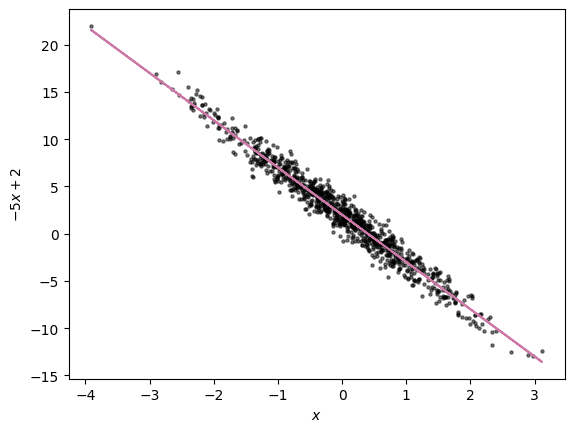

In [ ]:
import matplotlib.pyplot as plt

n_points = 1000

# generate normally distributed x values
x = torch.randn((n_points, 1))

# generate y values with normally distributed error
y = -5 * x + 2 + torch.randn(n_points, 1)

plt.xlabel('$x$')
plt.ylabel('$-5x + 2$')

# if using the GPU, move tensors to CPU to plot
plt.scatter(x.cpu(), y.cpu(), s=5, c='black', alpha=0.5)
plt.plot(x.cpu(), (-5 * x + 2).cpu(), c='#CC79A7');

Typically when solving OLS linear regression, you either compute an analytical solution for the parameters using the Normal Equation $\hat{\mathbf{w}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ (if feasible given data constraints), or solve for the gradient of the cost function w.r.t. the parameters symbolically by hand (to then program into SGD):

$$
\frac{\partial}{\partial w_j} J(w) = 2 (h_w(x) - y)x_j
$$
&nbsp;

In our case we _will_ use minibatch SGD, but instead of coding $\frac{\partial}{\partial w_j} J(w)$ directly into the optimization algorithm, we will use the magic of PyTorch's `autograd` to automatically differentiate the cost function.

> For OLS linear regression this is very much overkill, but the beauty of `autograd` is that the code to automatically differentiate linear regression and an incredibly deep neural network is essentially the same. And even though you probably won't use PyTorch for optimizing such a simple hypothesis function, the rest of the code for the training loop will remain unchanged when we move onto more complicated deep neural networks.

In [ ]:
from numpy.random import randint

# hyperparameters
n_iter, lr, batch_size = 25, 0.05, 4

# initialize parameters for slope and intercept
w = torch.normal(mean=0, std=0.01, size=(1,), requires_grad=True, device=device)
b = torch.zeros((1,), requires_grad=True, device=device)

# our hypothesis function
h = lambda x: w * x + b

# loss function for an individual data point
mse = lambda y_hat, y: (y_hat - y) ** 2

# begin the minibatch SGD training loop
for _ in range(n_iter):
    # randomly sample batch_size indices
    indexes = np.random.permutation(len(x))[:batch_size]

    # compute average loss for batch
    loss = mse(h(x[indexes]), y[indexes]).mean()

    # BACKPROPAGATE!
    loss.backward()

    # update parameters and reset gradients for next loop
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad

        w.grad.zero_()
        b.grad.zero_()

print(f"The true values of w, b are -5, 2 but the model estimated {w[0]:.2f}, {b[0]:.2f}")

The true values of w, b are -5, 2 but the model estimated -4.94, 1.97


We can see here that while the estimated values for $w$ and $b$ are close to the ground truth values, but they are not exactly equal. Since the OLS cost function is convex, this is a result of using minibatch SGD with a non-optimal learning rate for a finite number of iterations. Try decreasing the learning rate to take smaller "steps" with each SGD iteration and run the optimization loop for more iterations to see if you can get more accurate estimates for $w$ and $b$.

## From Lines to Layers

<figure>
<img alt="Linear regression is actually equivalent to a fully connected single layer neural network (without an activation function)" src="https://jonathandinu.github.io/generative-ai-notebooks/images/linear-nn-layers.png">

<figcaption>Linear regression is actually equivalent to a fully connected single layer neural network without an activation function (really just a neuron).</figcaption>
</figure>

---
&nbsp;

To make the conceptual jump from OLS linear regression to a single layer neural network, it is really just a matter of notation. Mathematically, each neuron in a graphical depiction of a neural network represents a linear combination of its inputs, computed as the sum across all input nodes of the values of the previous nodes multiplied by the weights on the incoming edges. The above figure corresponds to:

&nbsp;
$$
\hat{y} = f(\mathbf{x}) = w_1x_1 + w_2x_2 + \dots + w_nx_n
$$
&nbsp;

Equivalently, we can rewrite our linear regression implementation from above using PyTorch's neural network module `nn`.

In [ ]:
from torch import nn

# object oriented container for PyTorch neural networks
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # fully connected layer with 1 input node and 1 output node
        self.func = nn.Linear(1, 1)

    # represents a forward pass through the network
    def forward(self, x):
        return self.func(x)

# instantiate our `nn.Module`
clf = LinearRegression()
print(clf)

# calling a `nn.Module` runs the `forward()` function.
pred = clf(x[0])

# gradient computation and backpropagation work transparently
loss = mse(pred, y[0])
loss.backward()

LinearRegression(
  (func): Linear(in_features=1, out_features=1, bias=True)
)


> Again, for just a simple OLS linear regression using the full force of Pytorch's `nn.Module` class is very much overkill, but the code scaffold will largely remain unchanged when you move on to much more complex deep neural networks. Additionally, subclassing `nn.Module` provides the `LinearRegression` object with all the goodness of the built-in functions and attributes of `nn.Module`.

In [ ]:
# truncate the output since there are a lot of methods...
clf.__dir__()[-10:]

['set_extra_state',
 'share_memory',
 'state_dict',
 'to',
 'to_empty',
 'train',
 'training',
 'type',
 'xpu',
 'zero_grad']

## Making a Line Classify

|  |  |
|:--:|:--:|
|![](https://jonathandinu.github.io/generative-ai-notebooks/images/log-reg.png)| ![](https://jonathandinu.github.io/generative-ai-notebooks/images/linear-seperator.png)|

Right now, our "baby neural network" performs regression, since it outputs a continuous value from the last node. To turn this continuous output into a discrete classification, we can threshold this raw output---say `0` if it is less than a particular value and `1` if it is greater---but there are some additional desiderata we want from a classifier.

For one, there is no guarantee that the output of a linear combination of inputs will be bounded between reasonable values or sum to one (when doing multi-class clasification). To address both of these issues, we can feed the output through the sigmoid function, which is bounded between 0 and 1. And in doing so we have arrived at logistic regression (with Pytorch we just need to add a `nn.Sigmoid()`)!

\
\begin{align*}
\sigma(f(\mathbf{x})) & = \frac{1}{1 + e^{-f(\mathbf{x})}} \\
& = \frac{1}{1 + e^{-(w_1x_1 + w_2x_2 + \dots + w_nx_n)}}
\end{align*}

&nbsp;

$$
y =
   \begin{cases}
      0 & \sigma(f(\mathbf{x}))\leq 0.5 \\
      1 & otherwise.
   \end{cases}
$$


> This type of single layer, fully connected, feedforward neural network historically was called a [perceptron](https://blogs.umass.edu/brain-wars/files/2016/03/rosenblatt-1957.pdf) (when the [heaviside step-function](https://en.wikipedia.org/wiki/Heaviside_step_function) is used) and dates back to 1957---nearly predating the coining of "Artificial Intelligence" [itself](http://jmc.stanford.edu/articles/dartmouth/dartmouth.pdf). If the heaviside step-function is swapped for the sigmoid (or logistic) function, the network becomes equivalent to _Logistic Regression_.

## Connecting the Dots

<figure>
<img alt="A fully connected multilayer neural network. Each layer is fully connected to the previous/next, resulting in _each_ node at layer $l$ receiving as input the values from _every_ node at layer $l-1$" src="https://jonathandinu.github.io/generative-ai-notebooks/images/deep-nn-schematic.png">

<figcaption>A fully connected multilayer neural network. Each layer is fully connected to the previous/next, resulting in <i>each</i> node at layer $l$ receiving as input the values output from <i>every</i> node at layer $l-1$.</figcaption>
</figure>

---
&nbsp;

The magic of neural networks is that they are infinitely composable---as long as the functions are differentiable and you have enough computational resources. This flexibility is one of the reasons why they excel at a very diverse set of tasks and have been adopted by most every domain. To go from a single layer neural network to a multilayer neural network, you can simply use the outputs from the nodes at one layer as the inputs for the next.

In the context of a _multilayer_ neural network, when a non-linear function (like the sigmoid) is applied to the output of an intermediate hidden layer node, it is called an _activation function_... because [neurons](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1392413/). Each node and activation function combination acts as a sort of "gate" that allows a variable amount of signal to pass through the nodes of the network, depending on the given input datum. And the output layer takes this signal that has been propagated through the entire network to make a "decision" in the form of a prediction.

> Again and again, as with most things related to deep neural networks, the choice of activation function itself is an [active research area](https://arxiv.org/abs/1710.05941), with new methods constantly being developed. One of the most commonly encountered is the [ReLU function](https://icml.cc/Conferences/2010/papers/432.pdf), due to its conceptual simplicity, computational efficiency, and generally good performance on a broad set of tasks---though the "dying ReLU" is a common enough of a problem to warrant [warnings](https://developers.google.com/machine-learning/crash-course/training-neural-networks/best-practices#dead-relu-units) and [research](https://arxiv.org/abs/1903.06733).
>
> Because of its advantages, it is usually a good choice to start with as a baseline, unless a particular architecture necessitates a specific activation function---i.e. the popular [BERT language model](https://arxiv.org/abs/1810.04805) uses [Gaussian Error Linear Units](https://arxiv.org/abs/1606.08415) (GELU). But either way, it is usually easy enough to swap them, since `torch.nn` provides a unified interface for activation functions.


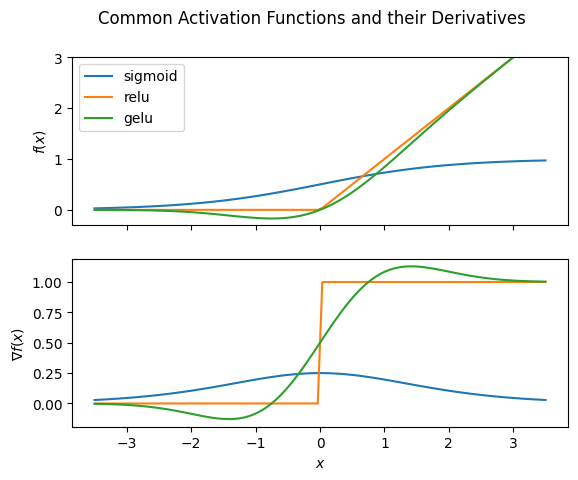

In [ ]:
from torch.nn import functional as F

fig, axs = plt.subplots(2, sharex=True)
x = torch.linspace(-3.5, 3.5, 100, requires_grad=True)

# tensor which doesn't compute gradients for `backward()`
ones = torch.ones_like(x)

for activation in ["sigmoid", "relu", "gelu"]:
    # lookup activation function by name
    fun = getattr(F, activation)
    val = fun(x)

    # compute the gradient of activation function
    val.backward(gradient=ones)

    #  plot activation function and its gradient
    axs[0].plot(x.detach().cpu(), val.detach().cpu(), label=activation)
    axs[1].plot(x.detach().cpu(), x.grad.cpu(), label=activation)

    # zero out gradient for next activation function
    x.grad.zero_()

# adjust plot to make it look nice
axs[0].set(ylabel='$f(x)$')
axs[0].set_ylim(-0.3, 3)
axs[0].legend(loc=2);
axs[1].set(xlabel='$x$', ylabel='$\\nabla f(x)$')
fig.suptitle('Common Activation Functions and their Derivatives');

Activation functions are not just fancy thesholding functions however, but actually core to the expressivity of deep neural networks. When a neural network with _at least one_ hidden layer uses non-linear activation functions, it [can be shown](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208) that it can actually approximate to arbitrary precision any continuous function.

> The gradient of each activation function is also plotted above, since it can be as important (if not more) than the function itself for certain domains and applications. I might give this a proper treatment when I/we move onto more complex architectures, but it ultimately results from the fact that the backpropagation algorithm __repeated applies the chain rule__ when computing the partial derivatives of the parameters w.r.t. the inputs.

## Putting it All Together

Computing the derivatives of a potentially arbitrarily deep neural network _by hand_ is not only arduous, but potentially impossible. And even with the tools in place to perform [computational automatic differentiation](https://www.osti.gov/servlets/purl/5254402), it was not until computational resources and [techniques](https://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf) caught up with the demands of deep neural networks that widespread adoption happened (outside of research).

With PyTorch and its `nn` module, it is now fortunately somewhat trivial to move from a single layer neural network to multilayer neural networks.

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # just add layers!
        self.layers = nn.Sequential(
            nn.Linear(2, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
        )

    # represents a forward pass through the network
    def forward(self, x):
        return self.layers(x)

net = Net()

> In the code above I used the [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) container, which is an alternate method for defining a series of layers. The advantage of this approach is that the container automatically takes care of piping the output of one layer as the input to the next layer. It also makes the code for the forward pass much more concise, especially for networks with many layers.

## The Possibilities of PyTorch

This unfortunately brings us to the end of our time together (for now), so I wanted to leave you with a few last notes on PyTorch, as well as some context as to where PyTorch fits into the much larger (and constantly growing) deep learning ecosystem.

### Module vs. Functional API

Pytorch actually has two slightly different interfaces to the `nn` module, each with a different use case.

The [Module API](https://pytorch.org/docs/stable/nn.html) defines layers as objects, which themselves are `nn.Module`s. These objects internally hold the state for any learnable parameters, i.e. for weights and biases. This makes them convenient for defining any layers with learnable parameters, or for using them with other `nn` modules (like the `Sequential` container).

The [Functional API](https://pytorch.org/docs/stable/nn.functional.html) on the other hand defines slightly more low level _stateless_ functions. With this interface, you do not need to initialize (or call) any objects before using them, every operation is just a stateless function that takes an input and returns an output. While their stateless nature makes them convenient for operations without any learnable parameters (like activation and loss functions), you have to manually manage any tensors that will update throughout the training process (like the weights and biases).

Since both APIs perform identical computational operations for equivalent methods (`nn.Relu()` vs `F.relu()`), ultimately whichever one you choose is a matter of personal preference and style.


### The Deep Learning Software Trilemma

![](https://jonathandinu.github.io/generative-ai-notebooks/images/dl-framework-simplex.png)

If you are reading this post, I will assume that you either:

- are somewhat new to deep learning software altogether
- already know how to use another framework and are looking to learn Pytorch

In either case, it will be helpful to understand where PyTorch fits into the grand scheme of things, what its strengths/weaknesses are, and why you might choose it over alternative competing technology.

The figure above is what I like to call the "deep learning software trilemma", analogous to other [trilemmas](https://nvlabs.github.io/denoising-diffusion-gan/) (that seem to be [pervasive](https://en.wikipedia.org/wiki/CAP_theorem) in computer science ;). In _this_ compromise that we must make when choosing a framework for deep learning, roughly it involves choosing between varying amounts of:

- Flexibility and Expressiveness (research)
- Reliability and Robustness (production)
- Ease and Speed of Use (ergonomics)

Now any sort of gross categorization like this is bound to upset a lot of people... "[Keras](https://keras.io/) is just as flexible as [JAX](https://jax.readthedocs.io/en/latest/)", "[Tensorflow](https://www.tensorflow.org/) is easier to use than Keras (for what I do)", "more research papers use PyTorch than any other framework", etc., etc. These are just heuristics and how _I_ organize them all in my head.

For me, I see PyTorch as something of the "Python of deep learning frameworks", not because it uses Python (all the others do too), but because it is the second best at everything. And that is a huge compliment, it truly is a jack of all trades framework and my "daily driver" so to say, unless a specific project necessitates me using a particular framework. Additionally, it uses a very similar API design as the [original Lua Torch](https://publications.idiap.ch/downloads/reports/2002/rr02-46.pdf), which not only has stood the test of time more so than any other framework, but also is a joy to teach with (and for others to learn with).

> It is also worth pointing out that while PyTorch was originally stewarded by Facebook/Meta, it is now a [proud member of the Linux Foundation](https://www.linuxfoundation.org/blog/blog/welcoming-pytorch-to-the-linux-foundation) family (while Tensorflow, Keras, and JAX are all stalwartly Google projects...).

### Going Deeper

I intentionally tried to keep this post succinct (not sure how well I did 😅)... I will hopefully have the motivation to keep writing more posts like this on other deep generative modeling/deep learning/generative AI topics, but even if this is the one and only, there are thankfully a glut of resources on the internet covering this type of stuff.

If you are interested in a more thorough (and proper) treatment of what I covered in this post, I highly recommend the [fast.ai](https://www.fast.ai/) courses if you learn best with lectures/videos or [Dive into Deep Learning](https://d2l.ai/) if you prefer books/just want a reference. Both are freely available (the [fast.ai book](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527) is also quite good but I am not sure if it is freely available?).

And for more cutting edge applications, the [Hugging Face ecosystem](https://huggingface.co/) is built on top of PyTorch and keeps pretty good pace with implementations of current research as it comes out (notably the [Transformers](https://huggingface.co/docs/transformers/index) and [Diffusers](https://huggingface.co/docs/diffusers/index) libraries).

Till next time 👋

\- [@jonathandinu](https://twitter.com/jonathandinu)